# Классификация пород кошек и собак по лицу

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [12]:
!"C:\Program Files (x86)\GnuWin32\bin\wget.exe" http://www.soshnikov.com/permanent/data/petfaces.tar.gz

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc
--2024-10-09 02:01:09--  http://www.soshnikov.com/permanent/data/petfaces.tar.gz
Распознаётся www.soshnikov.com... 79.137.227.122
Устанавливается соединение с www.soshnikov.com|79.137.227.122|:80... соединение установлено.
Запрос HTTP послан, ожидается ответ... 200 OK
Длина: 24483412 (23M) [application/x-tar]
Сохраняется в каталог: `petfaces.tar.gz'.

     0K .......... .......... .......... .......... ..........  0%  174K 2m17s
    50K .......... .......... .......... .......... ..........  0%  365K 1m41s
   100K .......... .......... .......... .......... ..........  0%  658K 79s
   150K .......... .......... .......... .......... ..........  0%  331K 77s
   200K .......... .......... .......... .......... ..........  1%  833K 67s
   250K .......... .......... .......... .......... ..........  1%  350K 67s
   300K .......... .......... .......... .......... ..........  1%  695K 62s
   3

  7100K .......... .......... .......... .......... .......... 29%  354K 43s
  7150K .......... .......... .......... .......... .......... 30%  703K 43s
  7200K .......... .......... .......... .......... .......... 30%  348K 43s
  7250K .......... .......... .......... .......... .......... 30%  664K 43s
  7300K .......... .......... .......... .......... .......... 30%  350K 43s
  7350K .......... .......... .......... .......... .......... 30%  440K 43s
  7400K .......... .......... .......... .......... .......... 31%  510K 42s
  7450K .......... .......... .......... .......... .......... 31%  358K 42s
  7500K .......... .......... .......... .......... .......... 31%  681K 42s
  7550K .......... .......... .......... .......... .......... 31%  357K 42s
  7600K .......... .......... .......... .......... .......... 31%  678K 42s
  7650K .......... .......... .......... .......... .......... 32%  356K 42s
  7700K .......... .......... .......... .......... .......... 32%  419K 41s

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

data_dir = pathlib.Path('petfaces')

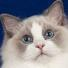

In [3]:
bassets = list(data_dir.glob('cat_Ragdoll/*'))
PIL.Image.open(str(bassets[0]))
# посмотрим на данные

In [4]:
batch_size = 32
img_size = (128, 128)

In [5]:
# 20% фотографий пойдут на валидацию
train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=0x1337,
  image_size=img_size,
  batch_size=batch_size)

Found 3211 files belonging to 35 classes.
Using 2569 files for training.


In [6]:
val = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=0x1337,
  image_size=img_size,
  batch_size=batch_size)

Found 3211 files belonging to 35 classes.
Using 642 files for validation.


In [7]:
class_names = train.class_names
cats_classes = []
dogs_classes = []

for i, class_name in enumerate(class_names):
    if class_name[:3] == 'cat':
        cats_classes.append(i)
    elif class_name[:3] == 'dog':
        dogs_classes.append(i)
    else:
        print('Error')

print('Cats classes:', cats_classes)
print('Dogs classes:', dogs_classes)

Cats classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Dogs classes: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
img_height = 128
img_width = 128
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

c:\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(num_classes),
    layers.Softmax()
])

In [12]:
top3_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', top3_acc])

In [13]:
epochs = 30

history = model.fit(
    train,
    validation_data=val,
    epochs=epochs
)

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.0579 - loss: 3.5069 - top_3_accuracy: 0.1556 - val_accuracy: 0.1994 - val_loss: 2.9177 - val_top_3_accuracy: 0.3925
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.2058 - loss: 2.8350 - top_3_accuracy: 0.4151 - val_accuracy: 0.2819 - val_loss: 2.5178 - val_top_3_accuracy: 0.5467
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.3087 - loss: 2.4417 - top_3_accuracy: 0.5521 - val_accuracy: 0.3879 - val_loss: 2.2728 - val_top_3_accuracy: 0.6168
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.3947 - loss: 2.1427 - top_3_accuracy: 0.6387 - val_accuracy: 0.4470 - val_loss: 2.0522 - val_top_3_accuracy: 0.6776
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.4261 - loss: 1.9835 - top_3_accuracy: 0.6765 - val_accuracy: 0.4860 - val_loss: 1.9405 - val_top_3_accuracy: 0.7134
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.4661 - loss: 1.8990 

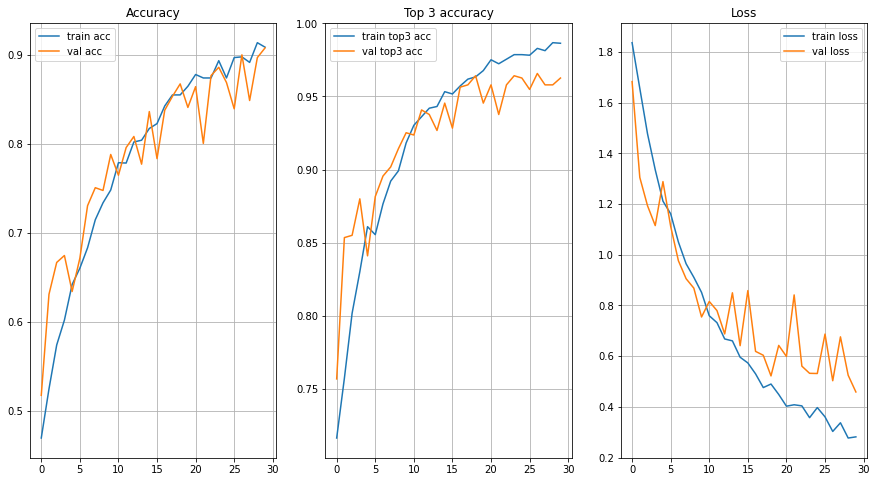

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='train acc')
plt.plot(epochs_range, val_acc, label='val acc')
plt.legend()
plt.grid()
plt.title('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, top3_acc, label='train top3 acc')
plt.plot(epochs_range, val_top3_acc, label='val top3 acc')
plt.legend()
plt.grid()
plt.title('Top 3 accuracy')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='train loss')
plt.plot(epochs_range, val_loss, label='val loss')
plt.legend()
plt.grid()
plt.title('Loss')

plt.show()

In [29]:
def count_binary_accuracy(model, val):
    correct = 0
    total = 0

    for x, y in val:
        y_pred = np.argmax(model.predict(x), axis=1)
        correct_cats = sum([y_pred[i] in cats_classes and y[i] in cats_classes for i in range(len(y))])
        correct_dogs = sum([y_pred[i] in dogs_classes and y[i] in dogs_classes for i in range(len(y))])
        correct += correct_cats + correct_dogs
        total += len(y)
    return correct / total

In [30]:
print('Cats vs dogs accuracy =', count_binary_accuracy(model, val))

1/1 [==============================] - 0s 69ms/step
Cats vs dogs accuracy = 0.9828660436137072


In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
def plot_confusion_matrix(model, val):
    y_real = np.array([])
    y_pred = np.array([])

    for x, y in val:
        y_real = np.concatenate((y_real, y), axis=None)
        y_pred = np.concatenate((y_pred, np.argmax(model.predict(x), axis=1)), axis=None)    
    conf_matrix = tf.math.confusion_matrix(y_real, y_pred, num_classes=num_classes)
    
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in class_names], columns = [i for i in class_names])
    plt.figure(figsize = (15, 15))
    sn.heatmap(df_cm, annot=True)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


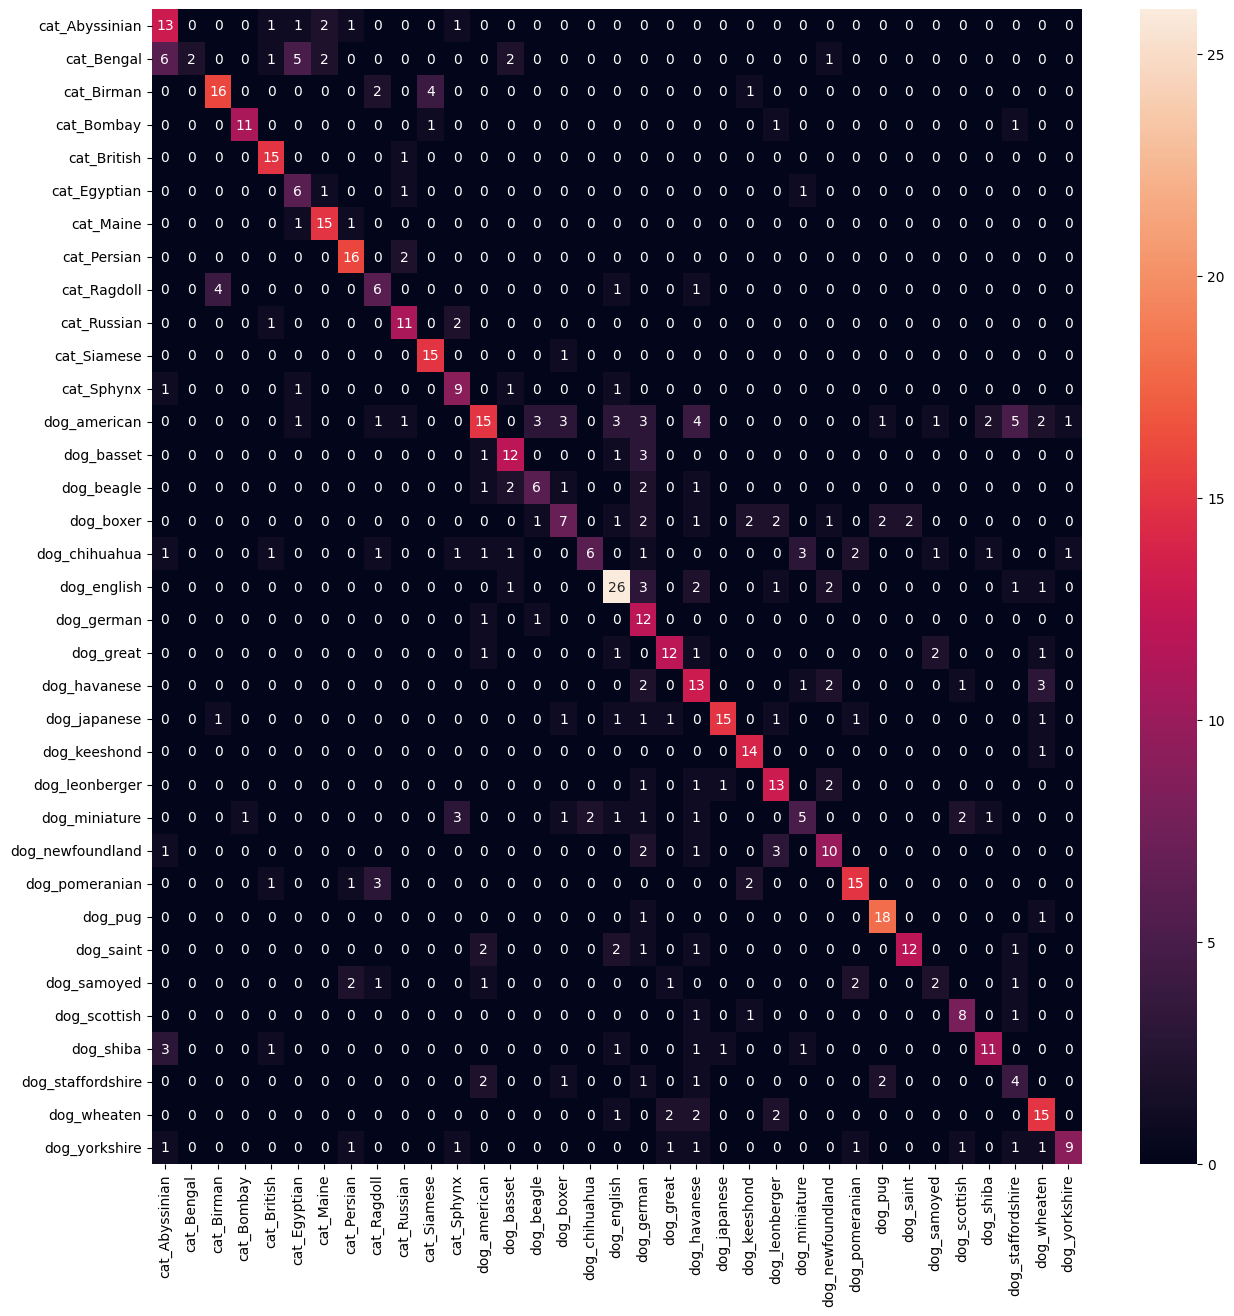

In [19]:
plot_confusion_matrix(model, val)